1)Importando as bibliotecas necessarias   


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


2)arquivos

In [35]:
with open('f1db_csv/drivers.csv') as file:
    drivers = pd.read_csv(file)
drivers

with open('f1db_csv/races.csv') as file:
    races = pd.read_csv(file)
races['date'] = pd.to_datetime(races['date'])
races.sort_values('date',inplace = True)

with open('f1db_csv/constructors.csv') as file:
    constructors = pd.read_csv(file) 

with open('f1db_csv/results.csv') as file:
    results = pd.read_csv(file)

with open('f1db_csv/status.csv') as file:
    status = pd.read_csv(file)
    status_dict = dict(zip(status.iloc[:,0],status.iloc[:,1]))

with open('f1db_csv/lap_times.csv') as file:
    lap_times = pd.read_csv(file)


3)adicionando colunas com dados gerados com base em outras

In [36]:

#criando uma novo coluna com pontuacao baseada nos padroes modernos para todos os pilotos
points_dict = {'1':25,'2':18,'3':15, '4':12, '5':10, '6':8, '7':6, '8':4, '9' : 2 , '10': 1 }
results['points_modern'] = results['position'].map(points_dict)
results['position'] = pd.to_numeric(results['position'], errors='coerce')
results.loc[(results['rank'] == '1') & (results['position'].astype(float) <= 10), 'points_modern'] += 1

#criando dicionarios {key:value} para equipes, pilotos e ano
drivers_keys =  drivers.set_index('driverId')['driverRef'].to_dict()
constructors_keys = constructors.set_index('constructorId')['constructorRef'].to_dict()
races_key = races.set_index('raceId')['year'].to_dict()
results['year'] = results['raceId'].map(races_key)
#criando coluna com valor de 1 para pilotos que abandonaram a prova por problema não causado por ele
results['abandoned_p'] = results['statusId'].astype(int).apply(lambda x: 1 if x > 4 and x not in 
[11,12,13,14,15,16,17,18,19,20,31,45,50,128,53,55,54,58,62,77,88,92,97,96,111,112,113,114,115,116,117,118,119,120,122,123,124,125,127,130,133,134] else 0)





In [37]:
#criando ranking de pilotos e mapeando seus nomes ao id
drivers_rec = results.groupby('driverId',as_index=False)['points_modern'].sum()
drivers_rec['driverName'] = drivers_rec['driverId'].map(drivers_keys)
#criando uma media de pontuacao por corrida levando apenas em conta corridas que nao foram terminadas por problema nao causado pelo piloto
drivers_rec['races'] = drivers_rec['driverId'].map(results['driverId'].value_counts())
drivers_rec['problem_sum'] = results[results['points'] == 0].groupby('driverId',as_index= False)['abandoned_p'].sum().iloc[:,1]
drivers_rec['pointsPerRace'] = drivers_rec['points_modern'] / (drivers_rec['races'] - drivers_rec['problem_sum'])
#criando colunas com a epoca de atuacao dos pilotos e equipes de atuação
constructors_racer = results.groupby('driverId')['constructorId'].apply(lambda x : x.unique())
def transform_constructor_ids(arr):
    return np.vectorize(constructors_keys.get)(arr)
drivers_rec['contructorsName'] = constructors_racer.apply(transform_constructor_ids).reset_index(drop=True)

epoca = results.groupby('driverId')['year'].agg(['min','max']).reset_index()
drivers_rec['epoca'] = epoca.apply(lambda x: f"({x['min']} - {x['max']})",axis = 1)
drivers_1 = drivers_rec[drivers_rec['races'] > 100]
#ranking baseado nos pontos por corridas terminadas e sem problemas.
drivers_1 = drivers_1.sort_values('pointsPerRace',ascending=False,ignore_index=True)
drivers_1.head(20)





,driverId,points_modern,driverName,races,problem_sum,pointsPerRace,contructorsName,epoca
0,1,4834.0,hamilton,313,14.0,16.167224,"[mclaren, mercedes]",(2007 - 2023)
1,117,2483.0,prost,202,39.0,15.233129,"[williams, ferrari, mclaren, renault]",(1980 - 1993)
2,102,1881.0,senna,162,37.0,15.048000,"[williams, mclaren, team_lotus, toleman]",(1984 - 1994)
3,30,3909.0,michael_schumacher,308,35.0,14.318681,"[ferrari, benetton, jordan, mercedes]",(1991 - 2012)
4,830,2069.0,max_verstappen,166,6.0,12.931250,"[toro_rosso, red_bull]",(2015 - 2023)
5,57,1382.0,hakkinen,165,51.0,12.122807,"[mclaren, team_lotus]",(1991 - 2001)
6,20,3325.0,vettel,300,25.0,12.090909,"[toro_rosso, bmw_sauber, red_bull, ferrari, as...",(2007 - 2022)
7,95,1509.0,mansell,192,66.0,11.976190,"[mclaren, williams, ferrari, team_lotus]",(1980 - 1995)
8,182,1341.0,lauda,174,61.0,11.867257,"[mclaren, brabham-alfa_romeo, brabham-ford, br...",(1971 - 1985)
9,356,939.0,jack_brabham,129,49.0,11.737500,"[brabham, brabham-ford, brabham-repco, brabham...",(1955 - 1970)


In [38]:
#criando ranking de equipes e mapeando ao id
teams_rec = results.groupby('constructorId',as_index=False)['points_modern'].sum()
teams_rec['teamName'] = teams_rec['constructorId'].map(constructors_keys)
#criando uma media de pontuaco mas agora sem ignorar problemas do carro
teams_rec['races'] = teams_rec['constructorId'].map(results['constructorId'].value_counts())
teams_rec['pointsPerRace'] = teams_rec['points_modern'] / teams_rec['races'] 
teams_rec = teams_rec[teams_rec['races'] > 150]
#ranking baseado nos pontos medios por carro
teams1 = teams_rec.sort_values('pointsPerRace',ascending=False,ignore_index=True)
teams1.head(10)

,constructorId,points_modern,teamName,races,pointsPerRace
0,131,7341.0,mercedes,566,12.969965
1,9,6978.0,red_bull,702,9.940171
2,6,21535.0,ferrari,2353,9.152146
3,1,13883.0,mclaren,1837,7.557431
4,22,3333.0,benetton,520,6.409615
5,3,9235.0,williams,1591,5.804525
6,170,1419.0,cooper-climax,268,5.294776
7,4,3840.0,renault,787,4.879288
8,208,711.0,lotus_f1,154,4.616883
9,32,3938.0,team_lotus,871,4.521240


/var/folders/t8/215299251g7_qkz41qkj_s7r0000gn/T/ipykernel_4944/3433510619.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot = championship[championship['constructorId'].isin(teams1['teamName'].head(4))][championship['year'] > 2015]


<AxesSubplot:xlabel='year', ylabel='points_modern'>

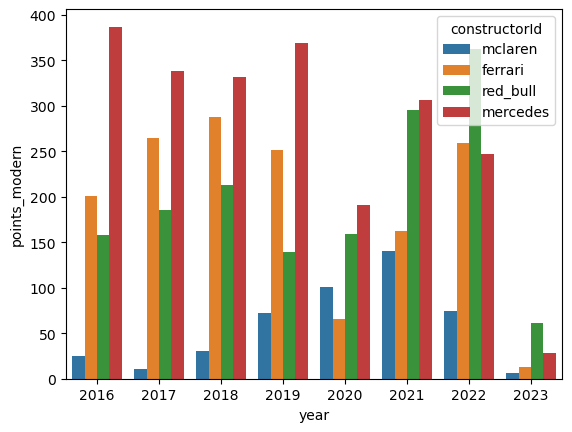

In [39]:
races_key = races.set_index('raceId')['year'].to_dict()
results['year'] = results['raceId'].map(races_key)
championship = results.groupby(['year','constructorId','driverId'])['points_modern'].sum()
championship = pd.DataFrame(championship)
championship = championship.rename(constructors_keys).rename(drivers_keys).reset_index()
plot = championship[championship['constructorId'].isin(teams1['teamName'].head(4))][championship['year'] > 2015]

sns.barplot(data = plot,y = 'points_modern',x = 'year',hue = 'constructorId',ci= None)



